# Household Vehicle Ownership – New Jersey

In [1]:
from utz import *
import plotly.express as px
from ire import export

In [2]:
default_colors = px.colors.qualitative.Plotly
colors = [ default_colors[i] for i in [2, 0, 3, 4, 1] ]
colors

['#00CC96', '#636EFA', '#AB63FA', '#FFA15A', '#EF553B']

In [3]:
import plotly.graph_objects as go

In [4]:
W, H = 700, 500
# W, H = 1200, 800

def plot(df, title, y=None, colors=colors, name=None, w=W, h=H, pct=False, legend=None, layout=None, xaxis=None, **kwargs):
    if y or 'value' not in kwargs.get('labels', {}):
        y = y or df.columns.name
        if 'labels' not in kwargs:
            kwargs['labels'] = {}
        kwargs['labels']['value'] = y

    fig = px.bar(df, **kwargs, color_discrete_sequence=colors)
    yaxis_kwargs=dict(
        yaxis=dict(
            tickformat=',.0%',
            range=[0,1],
        )
    ) if pct else dict()

    fig.update_layout(
        xaxis=xaxis,
        hovermode='x',
        **yaxis_kwargs,
        legend=legend,
        **(layout or {}),
    )
    fig.update_xaxes(tickangle=-45)
    fig.update_traces(hovertemplate=None)
    titled_fig = go.Figure(fig)
    titled_fig.update_layout(
        title=dict(text=title, x=0.5),
    )
    if name:
        fig.write_image(f'{name}.png', width=w, height=h)
        titled_fig.write_image(f'{name}_title.png', width=w, height=h)
    return export(titled_fig, name=name, show='png')

In [5]:
def ur_legend(title): 
    return dict(
        yanchor="top",
        y=0.96,
        xanchor="right",
        x=0.98,
        title=title,
    )

In [6]:
pct_legend = dict(
    orientation="h",
    yanchor="bottom",
    y=1.01,
    xanchor="center",
    x=0.5,
    title='Vehicles per household:',
)
pct_layout = dict(margin=dict(t=90, l=0, r=10, b=10))

In [7]:
url = 'https://api.census.gov/data/2021/acs/acs1?get=NAME,B08201_002E,B08201_003E,B08201_004E,B08201_005E,B08201_006E&for=county:*&in=state:34'
# d = pd.read_json(url)
d = pd.read_json('vehicles2021.json')
d

,0,1,2,3,4,5,6,7
0,NAME,B08201_002E,B08201_003E,B08201_004E,B08201_005E,B08201_006E,state,county
1,"Burlington County, New Jersey",8096,56805,68949,28093,13916,34,005
2,"Cumberland County, New Jersey",5053,16540,18524,10451,3315,34,011
3,"Hudson County, New Jersey",97657,130644,48242,11909,3548,34,017
4,"Middlesex County, New Jersey",23291,104574,122144,38014,19808,34,023
5,"Ocean County, New Jersey",14427,83106,94384,33775,15044,34,029
6,"Salem County, New Jersey",2715,6556,9633,3949,2120,34,033
7,"Union County, New Jersey",23055,71583,73878,24057,8819,34,039
8,"Atlantic County, New Jersey",15924,39974,37560,13979,4862,34,001
9,"Bergen County, New Jersey",28456,121851,135117,45014,21592,34,003


## Households x Vehicles x Municipality

Source: [api.census.gov].

[api.census.gov]: https://api.census.gov/data/2021/acs/acs1?get=NAME,B08201_002E,B08201_003E,B08201_004E,B08201_005E,B08201_006E&for=county:*&in=state:34

In [8]:
df = d.copy()
df.columns = df.iloc[0]
df = df.iloc[1:]
df = (
    sxs(
        df.NAME.str.extract(r'(?P<County>.*) County, New Jersey'),
        df,
    )
    .set_index('County')
    .drop(columns=['NAME', 'state'])
)
df = df.rename(columns={
    'B08201_002E': '0 vehicles',
    'B08201_003E': '1 vehicles',
    'B08201_004E': '2 vehicles',
    'B08201_005E': '3 vehicles',
    'B08201_006E': '4+ vehicles',
    'county': 'ccode',
})
df.columns.name = '# Households'
ccode = df.ccode
df = (
    df
    .drop(columns='ccode')
    .astype(int)
)
df = (
    df
    .assign(total=df.sum(1))
    .sort_values('total', ascending=False)
    .drop(columns='total')
)
export(df, 'hh')

Saved parquet to .ire/hh.parquet


# Households,0 vehicles,1 vehicles,2 vehicles,3 vehicles,4+ vehicles
County,,,,,
Bergen,28456,121851,135117,45014,21592
Essex,68739,133084,88384,23411,8835
Middlesex,23291,104574,122144,38014,19808
Hudson,97657,130644,48242,11909,3548
Monmouth,14932,80387,97181,38258,19980
Ocean,14427,83106,94384,33775,15044
Union,23055,71583,73878,24057,8819
Camden,20311,70247,75506,24154,10940
Morris,9031,57117,79365,31166,16168


In [9]:
pcts = df.div(df.sum(1), axis=0)
pcts.columns = ['0', '1', '2', '3', '4+']
pcts.columns.name = '% Households'
pcts = pcts.sort_values('0', ascending=False)
export(round(pcts * 100, 1), 'hh_pct')

Saved parquet to .ire/hh_pct.parquet


% Households,0,1,2,3,4+
County,,,,,
Hudson,33.4,44.7,16.5,4.1,1.2
Essex,21.3,41.3,27.4,7.3,2.7
Atlantic,14.2,35.6,33.4,12.4,4.3
Passaic,13.3,36.7,32.5,12.0,5.5
Union,11.4,35.5,36.7,11.9,4.4
Mercer,11.2,34.7,34.9,14.3,4.9
Salem,10.9,26.3,38.6,15.8,8.5
Camden,10.1,34.9,37.5,12.0,5.4
Cumberland,9.4,30.7,34.4,19.4,6.2


Saved plotly to .ire/households_by_vehicle_count.json


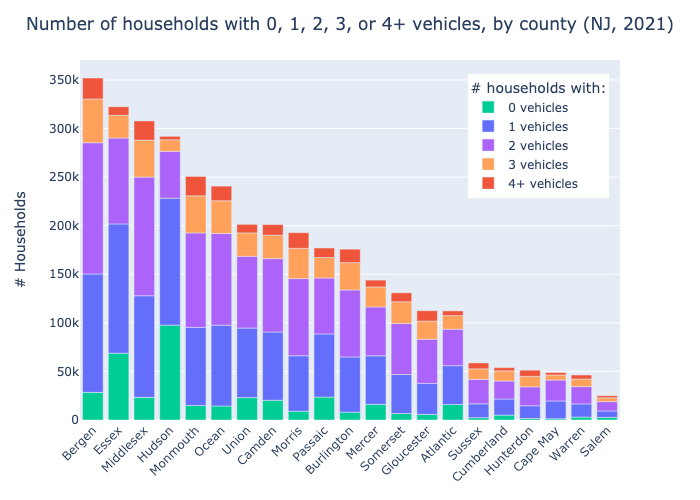

In [10]:
plot(
    df,
    title='Number of households with 0, 1, 2, 3, or 4+ vehicles, by county (NJ, 2021)',
    legend=ur_legend('# households with:'),
    name='households_by_vehicle_count',
)

Saved plotly to .ire/households_by_vehicle_count_pcts.json


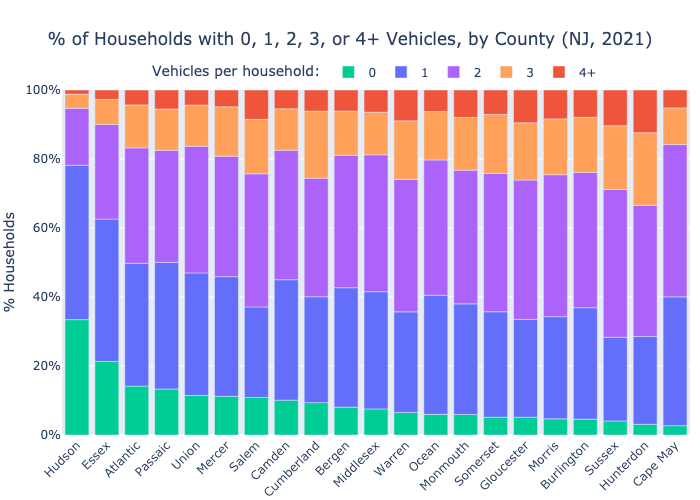

In [11]:
plot(
    pcts,
    title='% of Households with 0, 1, 2, 3, or 4+ Vehicles, by County (NJ, 2021)',
    pct=True,
    legend=pct_legend,
    layout=pct_layout,
    name='households_by_vehicle_count_pcts',
)

In [12]:
num_vehicles = df * [ idx for idx, name in enumerate(df.columns) ]
num_vehicles.columns.name = '# Vehicles'
num_vehicles = num_vehicles.rename(columns={
    f'{i} vehicles': f'{i}-vehicle households'
    for i in ['0', '1', '2', '3', '4+']
}).drop(columns='0-vehicle households')
total = num_vehicles.sum(1)
nv_pcts = num_vehicles.div(total, axis=0).sort_values('1-vehicle households', ascending=False)
nv_pcts.columns = ['1', '2', '3', '4+']
nv_pcts.columns.name = '% Vehicles'
num_vehicles['total'] = total
num_vehicles = num_vehicles.sort_values('total', ascending=False).drop(columns='total')
num_vehicles

# Vehicles,1-vehicle households,2-vehicle households,3-vehicle households,4+-vehicle households
County,,,,
Bergen,121851,270234,135042,86368
Middlesex,104574,244288,114042,79232
Monmouth,80387,194362,114774,79920
Ocean,83106,188768,101325,60176
Essex,133084,176768,70233,35340
Morris,57117,158730,93498,64672
Camden,70247,151012,72462,43760
Burlington,56805,137898,84279,55664
Union,71583,147756,72171,35276


In [13]:
nv_pcts

% Vehicles,1,2,3,4+
County,,,,
Hudson,0.471559,0.348259,0.128956,0.051226
Essex,0.320356,0.425511,0.169063,0.085070
Passaic,0.230000,0.406851,0.224912,0.138238
Atlantic,0.226509,0.425660,0.237632,0.110200
Union,0.219052,0.452149,0.220851,0.107948
Cape May,0.209409,0.495253,0.178470,0.116868
Camden,0.208151,0.447468,0.214714,0.129667
Mercer,0.207665,0.418209,0.257563,0.116564
Bergen,0.198618,0.440483,0.220119,0.140780


Saved plotly to .ire/vehicles_by_household_count.json


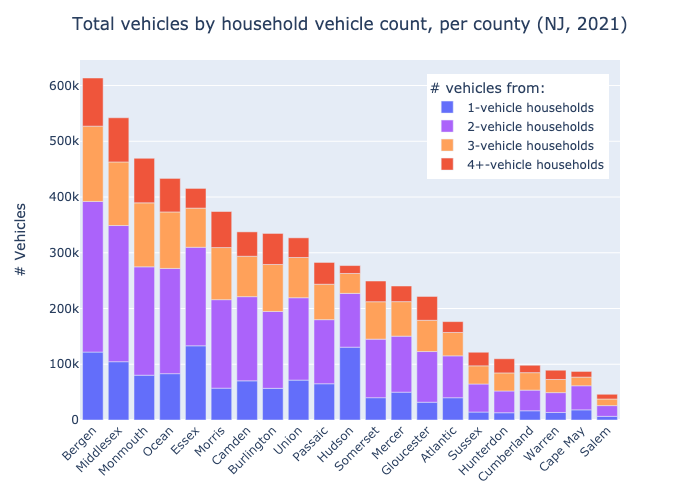

In [14]:
plot(
    num_vehicles,
    title='Total vehicles by household vehicle count, per county (NJ, 2021)',
    colors=colors[1:],
    legend=ur_legend('# vehicles from:'),
    name='vehicles_by_household_count',
)

Saved plotly to .ire/vehicles_by_household_count_pcts.json


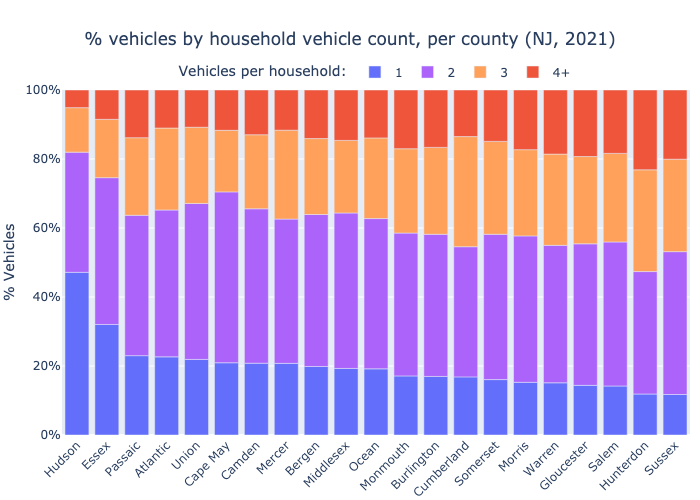

In [15]:
plot(
    nv_pcts,
    title='% vehicles by household vehicle count, per county (NJ, 2021)',
    pct=True,
    colors=colors[1:],
    legend=pct_legend,
    layout=pct_layout,
    name='vehicles_by_household_count_pcts',
)